## Module 4 Homework

In [1]:
# Import libraries/modules
import xarray as xr
import pandas as pd
import numpy as np
import dask
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from eofs.standard import Eof
from matplotlib.colors import Normalize
from scipy.stats import linregress
from scipy import signal

1) Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2023 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. The land sea mask is available here: https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc

In [2]:
# Import data from NCAR THREDDS file into an xarray
ds = xr.open_dataset('https://thredds.rda.ucar.edu/thredds/dodsC/aggregations/g/ds633.1/2/TP',
                     chunks={'time':'500MB'})

In [3]:
# Pull out the needed variables from the dataset
variables = ['2_metre_dewpoint_temperature_surface_Mixed_intervals_Average',
        'Sea_surface_temperature_surface_Mixed_intervals_Average',
        'Convective_available_potential_energy_surface_Mixed_intervals_Average']

# Select the three needed variables every 4th point to get 1 degree resolution
ds = ds[variables].sel(lat=slice(65, -65), lon=slice(120, 300))

In [4]:
# Save ds to netcdf file for future use
ds.to_netcdf('raw_data_ncar.nc')

In [5]:
# Open netcdf file
raw_ds = xr.open_dataset('raw_data_ncar.nc')

In [6]:
# Set data variables
sst_data = raw_ds['Sea_surface_temperature_surface_Mixed_intervals_Average']
cape_data = raw_ds['Convective_available_potential_energy_surface_Mixed_intervals_Average']
dewp_data = raw_ds['2_metre_dewpoint_temperature_surface_Mixed_intervals_Average']

In [7]:
# Calculate long-term mean & anomalies for SST, 2 meter Dewpoint, and CAPE

# SST
clim_sst = sst_data.sel(time=slice('1979', '2021')).groupby('time.month').mean('time')
sst_anomalies = sst_data.groupby('time.month') - clim_sst

# 2 meter Dew Point
clim_dewp = dewp_data.sel(time=slice('1979', '2021')).groupby('time.month').mean('time')
dewp_anomalies = dewp_data.groupby('time.month') - clim_dewp

# CAPE
clim_cape = cape_data.sel(time=slice('1979', '2021')).groupby('time.month').mean('time')
cape_anomalies = cape_data.groupby('time.month') - clim_cape

In [8]:
# Calculate the mean for each variable over the entire dataset
mean_sst = raw_ds['Sea_surface_temperature_surface_Mixed_intervals_Average'].mean(dim='time')
mean_dewp = raw_ds['2_metre_dewpoint_temperature_surface_Mixed_intervals_Average'].mean(dim='time')
mean_cape = raw_ds['Convective_available_potential_energy_surface_Mixed_intervals_Average'].mean(dim='time')

In [9]:
# Load the land-sea mask & drop 'time' element
lsm_dataset = xr.open_dataset('e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc')
land_sea_mask = lsm_dataset.isel(time=0).drop('time')

In [10]:
# Convert the longitude coordinates of the land-sea mask from -180 to 180 to 0 to 360
land_sea_mask['longitude'] = np.mod(land_sea_mask['longitude'], 360)

# Sort the land-sea mask by longitude & interpolate to match SST grid
land_sea_mask = land_sea_mask.sortby('longitude')
land_sea_mask_interp = land_sea_mask.interp(latitude=mean_sst.lat, longitude=mean_sst.lon, method='nearest')

# Apply mask to SST data
mean_sst_masked = mean_sst.where(land_sea_mask_interp.LSM == 0)

In [ ]:
# Create a masked SST plot
fig, ax = plt.subplots(figsize=(10, 6))
plot = mean_sst_masked.plot(ax=ax, cmap='RdBu_r', add_colorbar=False)

# Add a colorbar, title, labels
cbar = plt.colorbar(plot, ax=ax, label='Sea Surface Temperature (°K)')
plt.title('Mean Sea Surface Temperature, 1979-2021')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

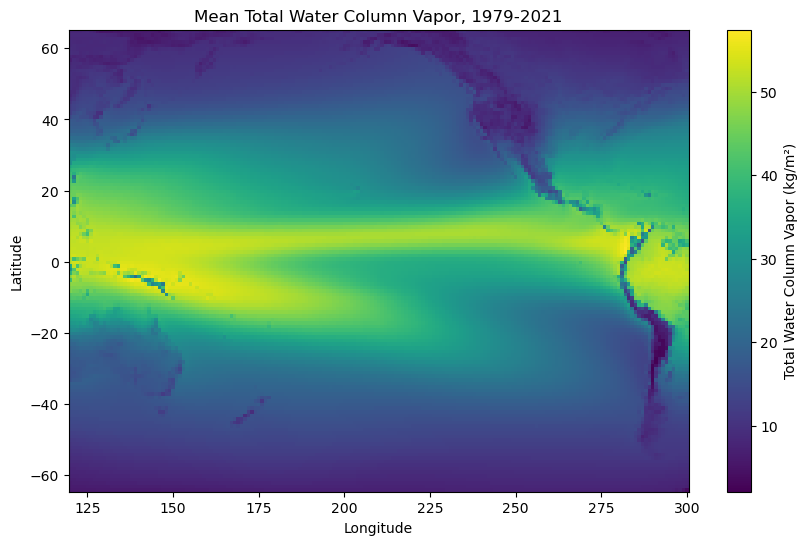

In [322]:
# Create a Water Vapor plot
fig, ax = plt.subplots(figsize=(10, 6))

# Add a colorbar, title, labels
plot = mean_vapor.plot(ax=ax, cmap='viridis', add_colorbar=False)
cbar = plt.colorbar(plot, ax=ax, label='Total Water Column Vapor (kg/m²)')
plt.title('Mean Total Water Column Vapor, 1979-2021')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


2) From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point), detrend, and standardize the SST anomalies. Standardization means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: 6.3. Preprocessing data — scikit-learn 1.1.2 documentation
Hints: Monthly data analysis — PyCLIM_101 0.2 documentation

In [323]:
# Deseasonalize the SST data
# Calculate the mean for each month across all years
monthly_means = sst_anomalies.groupby('time.month').mean('time')

# Calculate the overall mean for each point & the monthly anomalies
overall_mean = sst_anomalies.mean('time')
monthly_anomalies = monthly_means - overall_mean

# Subtract the corresponding monthly anomaly
deseasonalized_sst = sst_anomalies.groupby('time.month') - monthly_anomalies


In [324]:
# Deseasonalize the Water Vapor data
# Calculate the mean for each month across all years
monthly_means_v = vapor_anomalies.groupby('time.month').mean('time')

# Calculate the overall mean for each point & the monthly anomalies
overall_mean_v = vapor_anomalies.mean('time')
monthly_anomalies_v = monthly_means_v - overall_mean_v

# Subtract the corresponding monthly anomaly
deseasonalized_vapor = vapor_anomalies.groupby('time.month') - monthly_anomalies_v

In [325]:
# Detrend the SST Anomalies

# Interpolate and fill in NaN values, and flatten data
deseasonalized_sst_interp = deseasonalized_sst.interpolate_na(dim='time', method='linear')
deseasonalized_sst_fill = deseasonalized_sst_interp.fillna(0)
sst_data_flat = deseasonalized_sst_fill.stack(points=('lat', 'lon'))

# Detrend data
detrended_values = np.apply_along_axis(signal.detrend, axis=0, arr=sst_data_flat.values)

# Convert back to an xarray
detrend_sst = xr.DataArray(detrended_values, dims=sst_data_flat.dims, coords=sst_data_flat.coords).unstack('points')

In [326]:
# Detrend the Water Vapor Anomalies

# Interpolate and fill in NaN values, and flatten data
deseasonalized_vapor_interp = deseasonalized_vapor.interpolate_na(dim='time', method='linear')
deseasonalized_vapor_fill = deseasonalized_vapor_interp.fillna(0)
vapor_data_flat = deseasonalized_vapor_fill.stack(points=('lat', 'lon'))

# Detrend data
detrended_values_v = np.apply_along_axis(signal.detrend, axis=0, arr=vapor_data_flat.values)

# Convert back to an xarray
detrend_vapor = xr.DataArray(detrended_values_v, dims=vapor_data_flat.dims, coords=vapor_data_flat.coords).unstack('points')

In [327]:
# Standardize the SST Anomalies

# Calculate the long-term mean & standard deviation
long_term_mean = detrend_sst.mean(dim='time', skipna=True)
std_dev = detrend_sst.std(dim='time', skipna=True)

# Standardize the data
standardized_sst = (detrend_sst - long_term_mean) / std_dev

In [328]:
# Standardize the Water Vapor Anomalies

# Calculate the long-term mean & standard deviation
long_term_mean_v = detrend_vapor.mean(dim='time', skipna=True)
std_dev_v = detrend_vapor.std(dim='time', skipna=True)

# Standardize the data
standardized_vapor = (detrend_vapor - long_term_mean_v) / std_dev_v

3) Perform an EOF analysis (with cosine latitude weighting) on the SST anomalies and plot a map of the first 5 EOFs.

In [329]:
# Apply cosine latitude weighting
coslat = np.cos(np.deg2rad(standardized_sst.lat)).clip(0., 1.)
weights = np.sqrt(coslat)
weighted_sst = standardized_sst * weights

In [330]:
# Flatten the spatial dimensions & convert to numpy array
sst_flat = weighted_sst.stack(space=('lat', 'lon'))
sst_flat_np = sst_flat.values

# EOF analysis
solver = Eof(sst_flat_np)

In [331]:
# Compute the first 5 EOFs and PCs
eofs = solver.eofs(neofs=5)
pcs = solver.pcs(npcs=5, pcscaling=1)

# Variance from first 5 EOFs
variance_fraction = solver.varianceFraction(neigs=5)

In [332]:
# Find the number of lat/lon points in array
num_lat = len(standardized_sst.lat)
num_lon = len(standardized_sst.lon)

# Reshape the EOFs for plotting
eofs_reshaped = eofs.reshape((eofs.shape[0], num_lat, num_lon))

In [333]:
# Load the land-sea mask & drop 'time' element
land_mask = xr.open_dataset('e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc')
land_mask_data = land_mask.isel(time=0).drop('time')

In [334]:
# Convert the longitude coordinates of the land-sea mask from -180 to 180 to 0 to 360
land_mask_data['longitude'] = np.mod(land_mask_data['longitude'], 360)

# Sort the land-sea mask by longitude & interpolate to match SST grid
land_mask_data = land_mask_data.sortby('longitude')
land_mask_data_interp = land_mask_data.interp(latitude=standardized_sst.lat, longitude=standardized_sst.lon, method='nearest')

In [335]:
# Extract the DataArray from the xarray Dataset
land_sea_mask_array = land_sea_mask_interp['LSM'].values

# Mask land values
land_sea_mask_boolean = land_sea_mask_array > 0.05

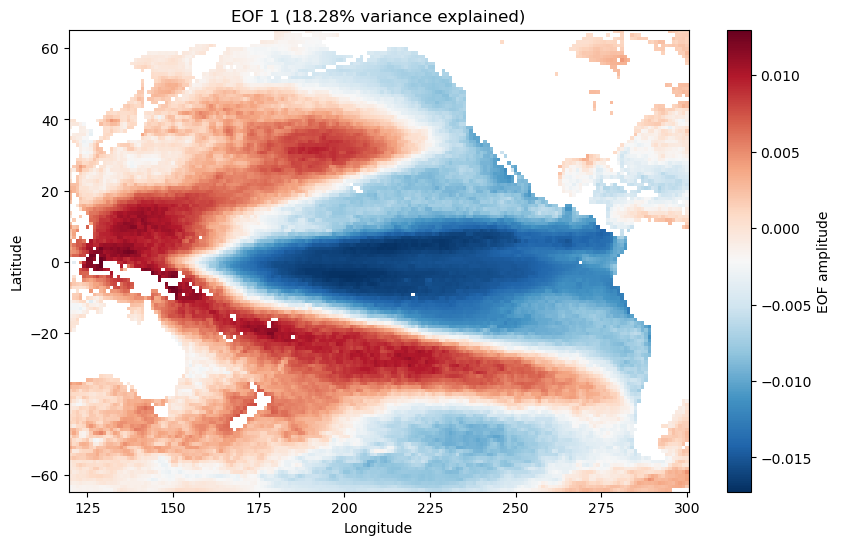

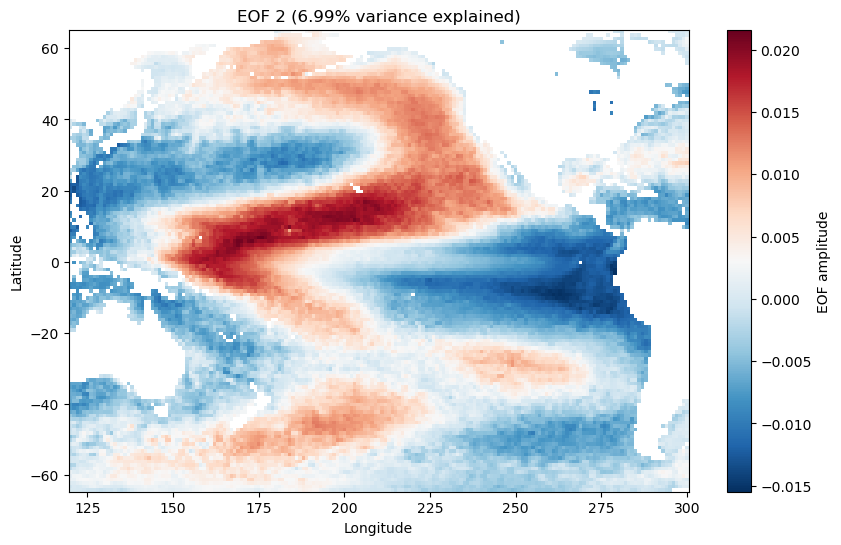

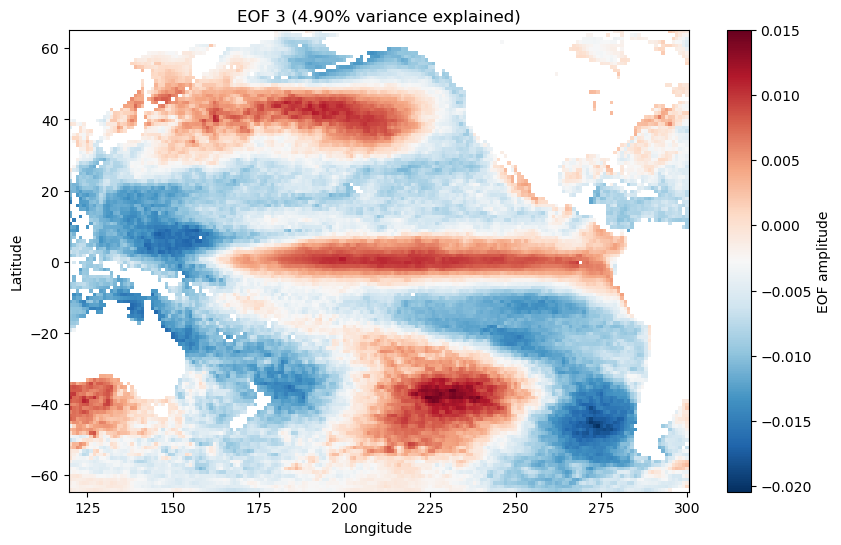

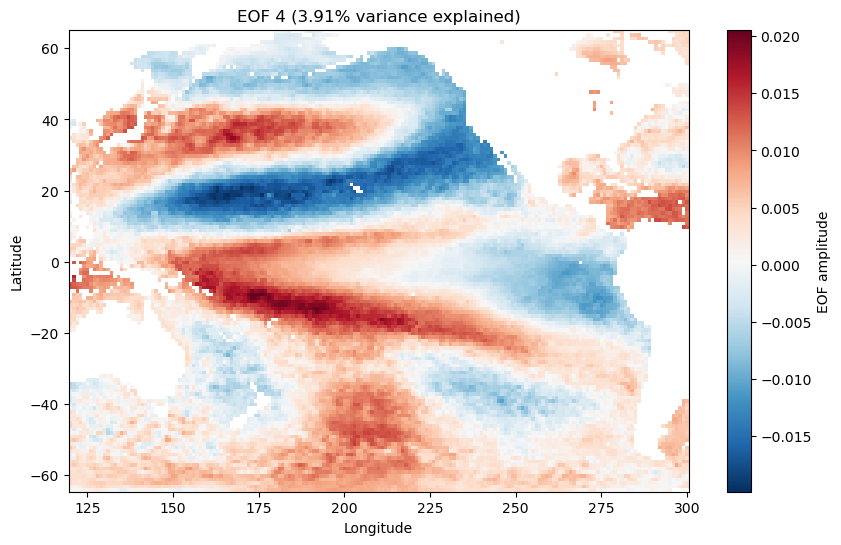

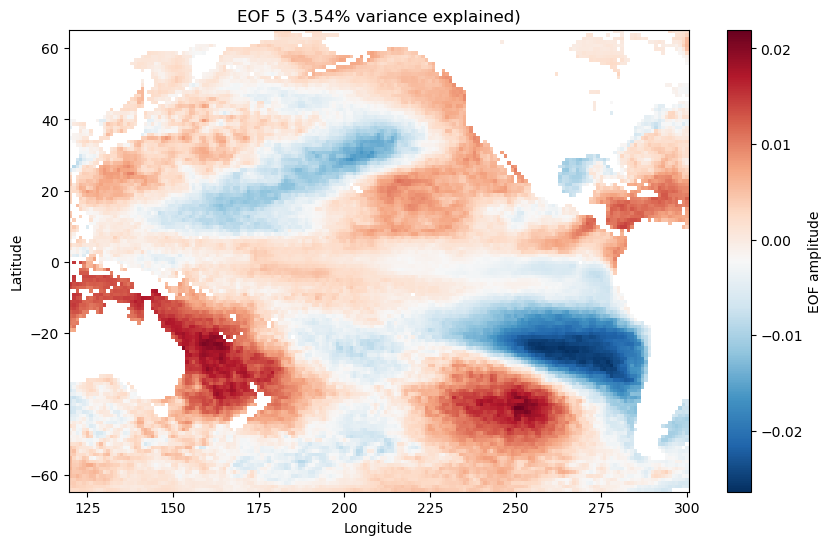

In [336]:
# Loop through the EOFs and plot the maps
for i, eof in enumerate(eofs_reshaped[:5]):
    # Reshape eof data to match spatially
    eof_reshaped = eof.reshape(weighted_sst.shape[1], weighted_sst.shape[2])

    # Apply the land-sea mask
    eof_masked = np.ma.masked_where(land_sea_mask_boolean, eof_reshaped)
    
    # Plot the map
    plt.figure(figsize=(10, 6))
    plot = plt.pcolormesh(standardized_sst.lon, standardized_sst.lat, eof_masked, cmap='RdBu_r', shading='auto')
    plt.colorbar(plot, label='EOF amplitude')
    variance_percent = variance_fraction[i] * 100  # Convert fraction to percentage
    plt.title(f'EOF {i+1} ({variance_percent:.2f}% variance explained)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

4) Plot the percent of variance explained by the first 10 EOFs.

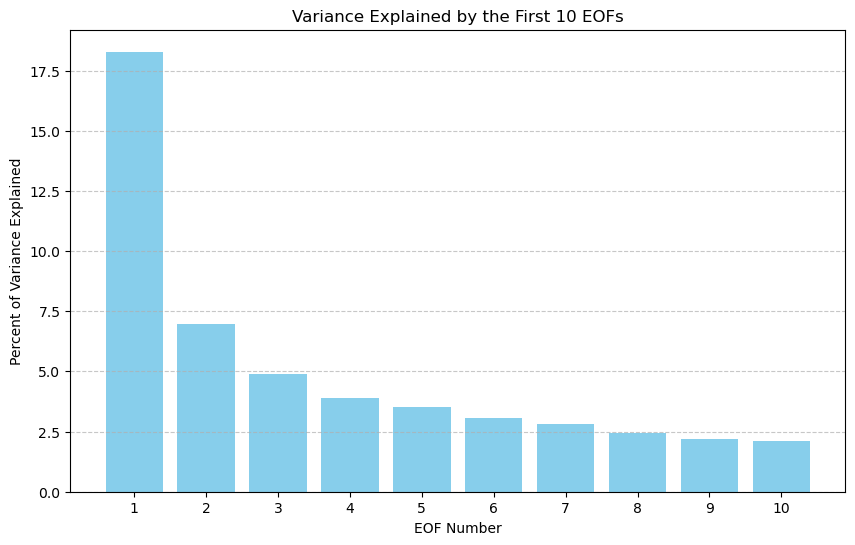

In [337]:
# Convert to percentages
variance_fractions = solver.varianceFraction(neigs=10)
variance_percentages = variance_fractions * 100

# Create an array of EOF numbers (1 through 10) for the x-axis labels
eof_numbers = np.arange(1, 11)

# Plot the chart
plt.figure(figsize=(10, 6))
plt.bar(eof_numbers, variance_percentages, color='skyblue')
plt.xlabel('EOF Number')
plt.ylabel('Percent of Variance Explained')
plt.title('Variance Explained by the First 10 EOFs')
plt.xticks(eof_numbers)  # Ensure x-axis labels match the EOF numbers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

5) Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient (xarray.corr) of the reconstructed monthly time series and the "observed" SST time series.

In [338]:
# Reconstruct the SST field using the first 5 EOFs
reconstructed_sst = solver.reconstructedField(neofs=5)

In [339]:
# Find the number of lat/lon values in deseasonalized_sst data
num_lat = deseasonalized_sst.shape[1]  # Number of latitudes
num_lon = deseasonalized_sst.shape[2]  # Number of longitudes

In [340]:
# Reshape the array for plotting
reconstructed_sst_reshaped = reconstructed_sst.reshape(-1, num_lat, num_lon)

In [341]:
# Creates an xarray from the numpy array
reconstructed_sst_xr = xr.DataArray(reconstructed_sst_reshaped, dims=deseasonalized_sst.dims, coords=deseasonalized_sst.coords)

In [342]:
# Calculate the Pearson's correlation between the reconstructed sst data and the deseasonalized sst data
correlation = xr.corr(deseasonalized_sst, reconstructed_sst_xr, dim='time')

C:\Users\dclay\anaconda3\envs\Mod4\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\dclay\anaconda3\envs\Mod4\lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [343]:
# Load the land-sea mask & drop 'time' element
lsm_dataset = xr.open_dataset('e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc')
land_sea_mask = lsm_dataset.isel(time=0).drop('time')

In [344]:
# Convert the longitude coordinates of the land-sea mask from -180 to 180 to 0 to 360
land_sea_mask['longitude'] = np.mod(land_sea_mask['longitude'], 360)

# Sort the land-sea mask by longitude & interpolate to match correlation grid
land_sea_mask = land_sea_mask.sortby('longitude')
land_sea_mask_interp = land_sea_mask.interp(latitude=correlation.lat, longitude=correlation.lon, method='nearest')

# Apply mask to correlation data
correlation_masked = correlation.where(land_sea_mask_interp.LSM == 0)

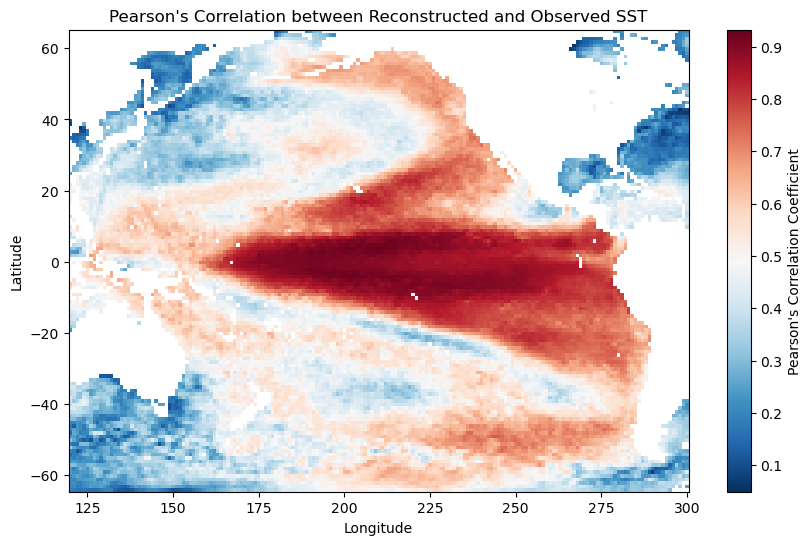

In [345]:
# Create a masked correlation plot
fig, ax = plt.subplots(figsize=(10, 6))
plot = correlation_masked.plot(ax=ax, cmap='RdBu_r', add_colorbar=False)

# Add a colorbar, title, labels
cbar = plt.colorbar(plot, ax=ax, label="Pearson's Correlation Coefficient")
plt.title("Pearson's Correlation between Reconstructed and Observed SST")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

6) Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean column water vapor anomalies (don't mask these over land for the plot). See anything interesting?

In [346]:
# Extract time coordinates and convert the first principal component (PC) to an xarray
time_coords = standardized_sst.time
eof1_pc_da = xr.DataArray(pcs[:, 0], dims=['time'], coords={'time': time_coords})

In [347]:
# Calculate Pearson's correlation between EOF1 and detrended, deseasonalized, and standardized vapor data
corr_eof1 = xr.corr(eof1_pc_da, standardized_vapor, dim='time')

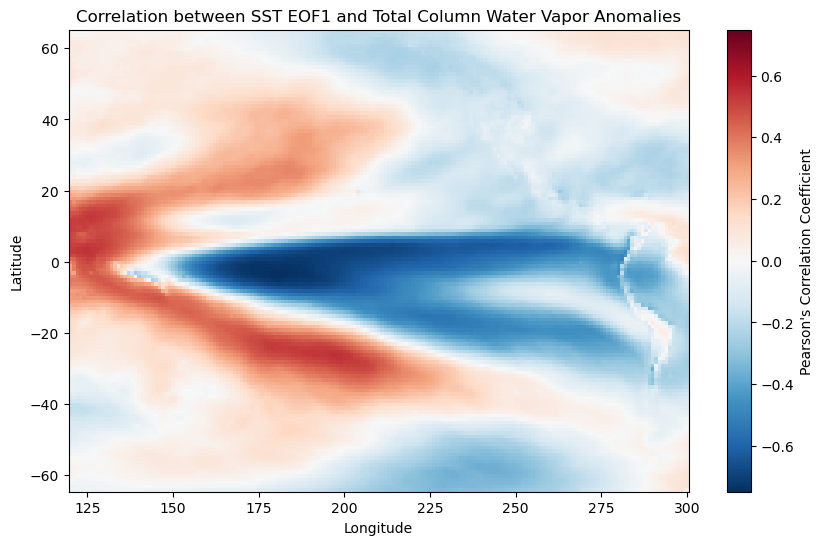

In [348]:
# Create the correlation plot
fig, ax = plt.subplots(figsize=(10, 6))
plot = corr_eof1.plot(ax=ax, cmap='RdBu_r', add_colorbar=False)

# Add a colorbar, title, labels
cbar = plt.colorbar(plot, ax=ax, label="Pearson's Correlation Coefficient")
plt.title("Correlation between SST EOF1 and Total Column Water Vapor Anomalies")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

There is strong negative correlation in the equatorial pacific between the EOF1 and water vapor anomalies. This pattern is very similiar to the La Niña phase of ENSO, where cooler ocean temperatures result in less water vapor in the atmosphere. Another interesting item I noticed was how dramatic the correlation values transition from ocean to land (i.e. along the Pacific Coast of North, Central, and South America). This aspect is greatly enhanced by the Andes Mountains in South America.